# **Problem Definition**

We consider building a bloom-date prediction model for the case of sakura in Tokyo. 
We have to fit the model to the data from the training years**(1961 to 2017 (Excluding 1966, 1971, 1985, 1994, and 2008 )**, then use the model to predict the bloom-date for each of the test years**(1966, 1971, 1985, 1994, and 2008)**. Three models to be applied to the data are described below.

1. **Prediction using the "600 Degree Rule"**
2. **Linear Regression Model: Transform to Standard Temperature**
3. **Predicting Bloom-date via Neural Network**    

## **Basics of the Sakura Bloom-cycle** 



In a year, sakura trees basically go through 4 phases: energy production, hibernation, growth, and of course flowering. These phases
roughly follow the seasons, but not exactly. <br>

   **Production phase：** Initial development of the buds（Summer-Fall） <br>
   **Hibernation phase：** Bud growth stops while the tree goes into hibernation（Late Fall-Winter） <br>
   **Growth phase：** Buds once again continue to grow when the tree comes out of its winter hibernation（Late Winter-Spring） <br>
   **Flowering phase：** The buds finally bloom in spring (as climate conditions allow), once they have been able to fully develop.（Spring） <br>
    
Each year, near the end of winter but before the trees finally bloom, the hibernation period ends. The sakura that rested through the winter once gain become metabolically active, and the buds continue to grow (though we may not immediately notice when this happens.) However, the cycle is not simply clockwork- for example, in places where the temperature is above 20℃ year-round, the trees are unable to hibernate sufficiently, and thus cannot blossom.
    
In this challenge, we have outlined the basic mechanism by which the sakura reach their eventual bloom-date. We consider building a bloom-date prediction model for the case of sakura in Tokyo, with the data split as follows: <br>
    
**Test years：** `1966, 1971, 1985, 1994, and 2008` <br>
**Training years:** `1961 to 2017 (Excluding the test years)` <br>
    
We should fit the model to the data from the training years, then use the model to predict the bloom-date for each of the test years. The 3 models to be applied to the data are described below.

#  **1. Importing Libraries**

Well, lets get started loading a bunch of libraries that i will be showing off with the data.

In [ ]:
import pandas as pd
from beautifultable import BeautifulTable
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import scipy.stats
import missingno as msno
from statistics import mean
import sklearn.neural_network as sknn
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
import math
import warnings
from sklearn.metrics import r2_score
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)


# **2. Source of Data:**

Acquired Sakura blooming data for Tokyo from `1961 to 2017` 
using the Japan Meteorological Agency website. We will load 
the data set for inspection purposes to get an idea of the data
 we're going to work with. The Pandas package helps us work 
with our dataset.

## **2.1 Load the data:**

In [ ]:
sakura_data = pd.read_csv('df.csv',header=0)

### **2.1.1 What types of data do i have?:**

In [ ]:
sakura_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20544 entries, 0 to 20543
Data columns (total 16 columns):
serial            20544 non-null int64
year              20544 non-null int64
month             20544 non-null int64
day               20544 non-null int64
local pressure    20544 non-null float64
sea pressure      20544 non-null float64
total preci       20544 non-null float64
hr1 preci         20544 non-null float64
min10 preci       20544 non-null float64
avg temp          20544 non-null float64
max temp          20544 non-null float64
min temp          20544 non-null float64
avg humid         20544 non-null int64
min humid         20544 non-null int64
sun hours         20544 non-null float64
bloom             20544 non-null int64
dtypes: float64(9), int64(7)
memory usage: 2.5 MB


### **2.1.2 Inspecting data:**

In [ ]:
print ('This dataset has {0} rows and {1} columns'.format(sakura_data.shape[0],sakura_data.shape[1]))
numeric_sakura_data = sakura_data.select_dtypes(include=[np.number])
cat_sakura_data = sakura_data.select_dtypes(exclude=[np.number])
print ("There are {} numeric and {} categorical columns in this dataset".format(numeric_sakura_data.shape[1],cat_sakura_data.shape[1]))

This dataset has 20544 rows and 16 columns
There are 16 numeric and 0 categorical columns in this dataset


### **2.1.3 Missing data:**

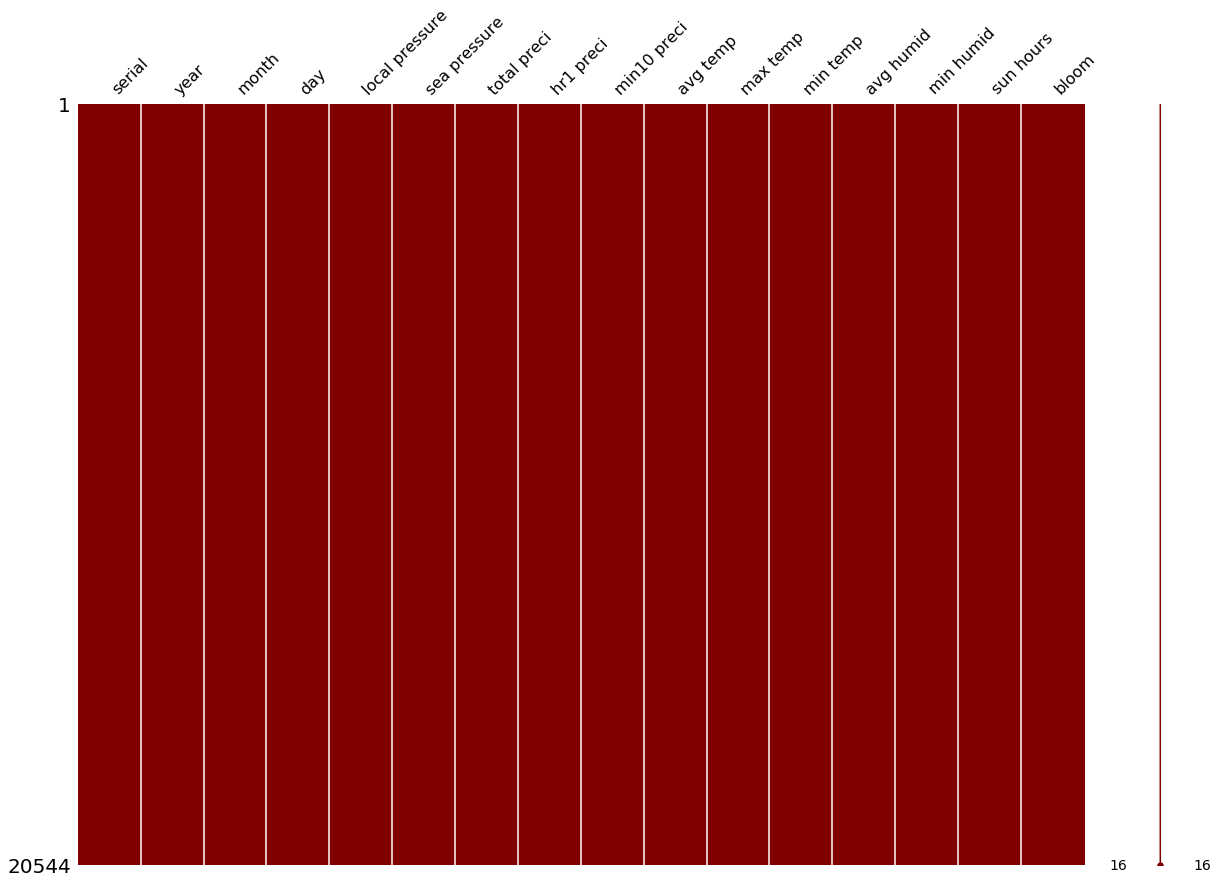

In [ ]:

sakura_data.columns[sakura_data.isnull().any()]
msno.matrix(df=sakura_data, figsize=(20,14), color=(0.5,0,0))

The white elements are absent here. There seems to be no columns containing nan.

In [ ]:
sakura_data=sakura_data.rename(columns = {'avg temp':'avgtemp'})
sakura_data_bloom = sakura_data[sakura_data.groupby('year')['bloom'].apply(lambda x: x.shift().eq(1).cumsum().eq(0))]
sakura_data_bloom = sakura_data_bloom[sakura_data_bloom["bloom"] == 1]
sakura_data_year=sakura_data_bloom["year"].tolist()
sakura_data_month=sakura_data_bloom["month"].tolist()
sakura_data_day=sakura_data_bloom["day"].tolist()
table = BeautifulTable()
table.column_headers = ["Year", "Month", "Bloomdate"]
for i in range(0,57):
    table.append_row([sakura_data_year[i],sakura_data_month[i],sakura_data_day[i]])
print(table)

+------+-------+-----------+
| Year | Month | Bloomdate |
+------+-------+-----------+
| 1961 |   4   |     1     |
+------+-------+-----------+
| 1962 |   4   |     1     |
+------+-------+-----------+
| 1963 |   4   |     1     |
+------+-------+-----------+
| 1964 |   4   |     2     |
+------+-------+-----------+
| 1965 |   4   |     2     |
+------+-------+-----------+
| 1966 |   3   |    20     |
+------+-------+-----------+
| 1967 |   3   |    30     |
+------+-------+-----------+
| 1968 |   3   |    29     |
+------+-------+-----------+
| 1969 |   4   |     6     |
+------+-------+-----------+
| 1970 |   4   |     7     |
+------+-------+-----------+
| 1971 |   3   |    30     |
+------+-------+-----------+
| 1972 |   3   |    28     |
+------+-------+-----------+
| 1973 |   3   |    31     |
+------+-------+-----------+
| 1974 |   4   |     2     |
+------+-------+-----------+
| 1975 |   3   |    29     |
+------+-------+-----------+
| 1976 |   3   |    22     |
+------+------


# **3. Prediction using the "600 Degree Rule"**



For a rough approximaton of the bloom-date, we start with a simple "rule-based" prediction model, called the "600 Degree Rule". The rule consists of logging the maximum temperature of each day, starting  on **February 1st**, and sum these temperatures until the sum surpasses 600$^\circ$C. The day that this happens is the predicted bloom-date. This 600$^\circ$C threshold is used to easily predict bloom-date in various locations varies by location. However, for more precise predictions, it should be set differently for every location. In this challenge, we verify the accuracy of the "600 Degree Rule" in the case of Tokyo.

From here-on, we refer to the bloom-date in a given year $j$ as $BD_{j}$. For each year in the training data, we will calculate the accumulated daily maximum temperature from February 1st to the actual bloom-date $BD_{j}$, and will also plot this accumulated value over the training period. Then, we will average this accumulated value as $T_{mean}$, and verify whether we should use 600$^\circ$C as a rule for Tokyo.

## **3.1 Train & Test data creation:**

In [ ]:
sakura_data_train=sakura_data.copy()
testyear_sakura=[1966,1971,1985,1994,2008]
trainyear_sakura = [e for e in list(range(1961,2018)) if e not in (1966,1971,1985,1994,2008)]
sakura_data_test = sakura_data.loc[sakura_data['year'].isin(testyear_sakura)]
sakura_data_train = sakura_data.loc[sakura_data['year'].isin(trainyear_sakura)]
sakura_data_train_Neural = sakura_data_train.copy()
sakura_data_test_Neural = sakura_data_test.copy()

No handles with labels found to put in legend.


638.3557692307693


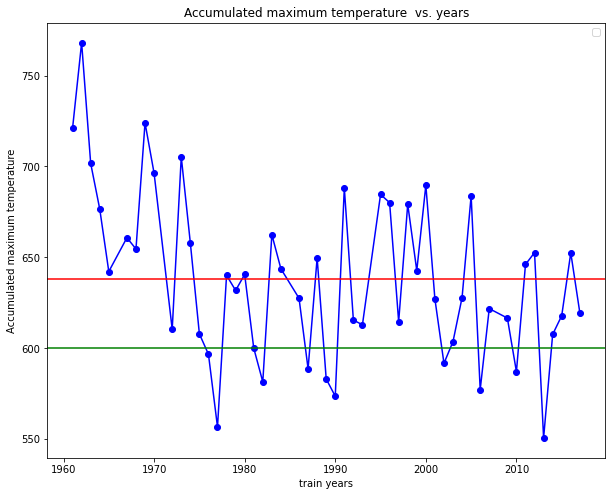

600 Deegree Rule is not applicable for Tokyo


In [ ]:
sakura_data_train_tmean = sakura_data_train[sakura_data_train["month"] != 1]
sakura_data_train_tmean = sakura_data_train_tmean[sakura_data_train_tmean.groupby('year')['bloom'].apply(lambda x: x.shift().eq(1).cumsum().eq(0))]
sakura_data_train_tmean=sakura_data_train_tmean.groupby(["year"])["max temp"].sum()
sakura_data_train_tmean = pd.DataFrame({'year':sakura_data_train_tmean.index, 'count':sakura_data_train_tmean.values})
Tmean = sakura_data_train_tmean['count'].sum()/len(sakura_data_train_tmean)
print (Tmean)
acuumulatedvalue = sakura_data_train_tmean["count"].tolist()
year=sakura_data_train_tmean["year"].tolist()
plt.plot(year, acuumulatedvalue, 'ob-')
plt.ylabel("Accumulated maximum temperature")
plt.xlabel("train years")
plt.title("Accumulated maximum temperature  vs. years")
plt.axhline(y=Tmean, color='r', linestyle='-')
plt.axhline(y=600, color='g', linestyle='-')
plt.legend()
plt.show()
print("600 Deegree Rule is not applicable for Tokyo")

## **3.2 Model comparison:**

We will use the average accumulated value $T_{mean}$ calculated earlier(see previous step) to predict $BD_{j}$ for each test year, and will calculate the error from the actual $BD_{j}$. We will also do comparison with the prediction results when 600$^\circ$C is used a threshold value.For evaluation of both models we will use the coefficient of determination ($R^2$ score).

In [ ]:
sakura_data_test_BD_compariosn = sakura_data_test[sakura_data_test["month"] != 1]
sakura_data_test_BD_compariosn=sakura_data_test_BD_compariosn.rename(columns = {'max temp':'maxtemp'})
sakura_data_test_BD_compariosn['avgcumulative'] = sakura_data_test_BD_compariosn.groupby(['year'])['maxtemp'].apply(lambda x: x.cumsum())

sakura_data_test_BD_compariosn.loc[:,'days'] =1
sakura_data_test_BD_compariosn['daycount'] = sakura_data_test_BD_compariosn.groupby(['year'])['days'].apply(lambda x: x.cumsum())
actual=[]
prediction=[]
prediction_600=[]
Tmean=638.3557692307693

for k in testyear_sakura:
    for i in list(range(1,1826)):
        if sakura_data_test_BD_compariosn.iloc[i].year == k:
            if sakura_data_test_BD_compariosn.iloc[i].bloom == 1 :
                actual.append(sakura_data_test_BD_compariosn.iloc[i].daycount+31)
                break
for k in testyear_sakura:
    for i in list(range(1,1826)):
        if sakura_data_test_BD_compariosn.iloc[i].year == k:
            if sakura_data_test_BD_compariosn.iloc[i].avgcumulative >= Tmean:
                prediction.append(sakura_data_test_BD_compariosn.iloc[i].daycount+31)
                break
for k in testyear_sakura:
    for i in list(range(1,1826)):
        if sakura_data_test_BD_compariosn.iloc[i].year == k:
            if sakura_data_test_BD_compariosn.iloc[i].avgcumulative >= 600:
                prediction_600.append(sakura_data_test_BD_compariosn.iloc[i].daycount+31)
                break
r2_600=r2_score(actual, prediction_600)                
print(('actual bloom date(Number of days) for test years'),actual)
print(("Prediction of bloom date(Number of days) based on Tmean=638.3557692307693:"),prediction)
print(("Prediction of bloom date(Number of days) based on Tmean=600:"),prediction_600)
print(("Test data Error based on mean value:"),np.abs(list(np.array(actual) - np.array(prediction))))
print(("Test data Error based on 600 degree rule:"),np.abs(list(np.array(actual) - np.array(prediction_600))))
print("Coefficient of determination for 600 degree rule:",r2_score(actual, prediction_600))
print("Coefficient of determination for mean value:",r2_score(actual, prediction))

actual bloom date(Number of days) for test years [79.0, 89.0, 93.0, 90.0, 82.0]
Prediction of bloom date(Number of days) based on Tmean=638.3557692307693: [82.0, 88.0, 91.0, 90.0, 85.0]
Prediction of bloom date(Number of days) based on Tmean=600: [79.0, 86.0, 88.0, 87.0, 83.0]
Test data Error based on mean value: [3. 1. 2. 0. 3.]
Test data Error based on 600 degree rule: [0. 3. 5. 3. 1.]
Coefficient of determination for 600 degree rule: 0.6793002915451896
Coefficient of determination for mean value: 0.8323615160349854


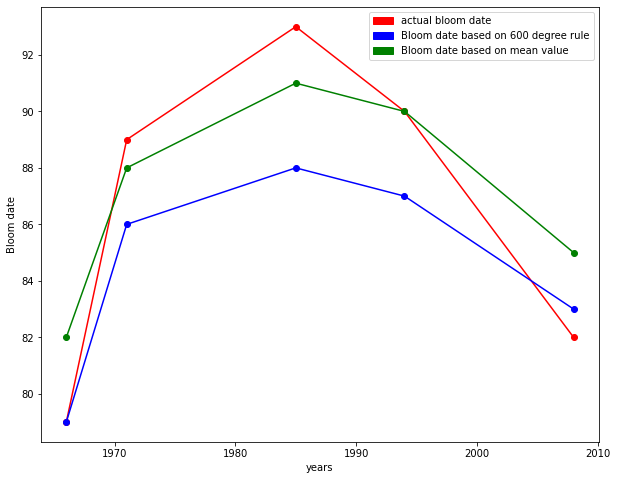

In [ ]:
plt.plot(testyear_sakura, actual, 'red',marker='o')
plt.plot(testyear_sakura, prediction_600, 'blue',marker='o')
plt.plot(testyear_sakura, prediction, 'green',marker='o')
plt.xlabel('years')
plt.ylabel('Bloom date')
red_patch = mpatches.Patch(color='red', label='actual bloom date')
blue_patch = mpatches.Patch(color='blue', label='Bloom date based on 600 degree rule')
green_patch = mpatches.Patch(color='green', label='Bloom date based on mean value')
plt.legend(handles=[red_patch, blue_patch, green_patch])
plt.show()

## **4. Linear regression model: transform to standard temperature** 

The year to year fluctuation of the bloom-date depends heavily upon the actual temperature fluctuation (not just the accumulated maximum). In order to get to a more physiologically realistic metric,  Sugihara et al. (1986) considered the actual effect of temperature on biochemical activity. They introduced a method of "standardizing" the temperatures measured, according to the fluctuation relative to a standard temperature.

In order to make such a standardization, we apply two major assumptions, outlined below.

#### **1) The Arrhenius equation:** <br>

The first assumption, also known in thermodynamics as the "Arrhenius equation", deals with chemical reaction rates and can be written as follows:

$$
k = A \exp{ \Bigl(- \frac{E_{a}}{RT}} \Bigr)
$$ <br>

Basically, it says that each reaction has an activation energy, $E_{a}$ and a pre-exponential factor $A$. Knowing these values for the particular equation, we can find the rate constant $k$ if we know the temperature, $T$, and applying the universal gas constant, $R = 8.314 \rm [J/K・mol]$.

#### **2) Constant output at constant temperature:** <br>

The second assumption, is simply that the output of a reaction is a simple product of the duration and the rate constant $k$, and that product is constant even at different temperatures.
    
$$
tk = t'k' = t''k'' = \cdots = \rm{const}
$$ <br>


Making the assumptions above, we can determine a "standard reaction time", $t_{s}$ required for the bloom-date to occur. We can do so in the following way:

<br>
$$
t_{s} = \exp \Bigl( \frac{E_{a}(T_{i, j} - T_{s})}{RT_{i, j}T_{s}}\Bigr)
$$ <br>

We define $T_{i, j}$ as the daily average temperature, and use a standard temperature of $T_{s} = 17^\circ\rm{C}$. For a given year $j$, with the last day of the hibernation phase set as $D_ {j}$, we define the number of "transformed temperature days",  $DTS_{ J}$,  needed to reach from $D_ {j}$ to the bloom-date $BD_{j}$ with the following equation:


<br>
$$
DTS_{j} = \sum_{i=D_{j}}^{BD_{j}} t_{s} = \sum_{i=D_{j}}^{BD_{j}} \exp \Bigl( \frac{E_{a}(T_{i, j} - T_{s})}{RT_{i, j}T_{s}}\Bigr)
$$ <br>



From that equation, we can find the average $DTS$ for $x$ number of years ($DTS_{ mean}$) as follows: 

<br>
$$
\begin{align}
DTS_{\rm{mean}} &= \frac{1}{x} \sum_{j}^{x} DTS_{j} \\
&= \frac{1}{x} \sum_{j}^{x} \sum_{i=D_{j}}^{BD_{j}} \exp \Bigl( \frac{E_{a}(T_{i, j} - T_{s})}{RT_{i, j}T_{s}}\Bigr)
\end{align}
$$ <br> <br>

In this part, we assume that $DTS_{ mean}$ and $E_{ a}$ are constant values, and we use the data from the training years to fit these 2 constants. This consists of 4 steps:
1. Calculate the last day of the hibernation phase $D_ {j}$ for every year $j$.
2. For every year $j$, calculate $DTS_{ j}$ as a function of $E_{ a}$, then calculate the average (over training years) $DTS_{ mean}$ also as a function of $E_{ a}$.
3. For every year $j$, and for every value of $E_{ a}$, accumulate $t_{s}$ from $D_ {j}$ and predict the bloom date $BD_{j}^{\rm{pred}}$ as the day the accumulated value surpasses $DTS_{ mean}$. Calculate the bloom date prediction error as a function of $E_{ a}$, and find the optimal $E_{ a}$ value that minimizes that error.
4. Use the previously calculated values of $D_ {j}$, $DTS_{ mean}$, and $E_{ a}$ to predict bloom-day on years from the test set.



According to Hayashi et al. (2012), the day on which the sakura will awaken from their hibernation phase, $D_{j}$, for a given location, can be approximated by the following equation:
<br> <br>
$$
D_{j} = 136.75 - 7.689 \phi + 0.133 \phi^{2} -1.307\ln L + 0.144T_{F} + 0.285T_{F}^2
$$ <br>

where $\phi$ is the latitude [°N], $L$ is the distance from the nearest coastline [km], and $T_{F}$ is that location's average temperature [°C] over the first 3 months of a given year. In the case of Tokyo, $\phi = 35°40'$ and $L=4\rm{km}$.

Now we will find the $D_{j}$ value for every year $j$ from 1961 to 2017 (including the test years), and will also plot this value on a graph. 

(In Section 3, we had assumed a $D_j$ of February 1st.)

[39.0, 42.0, 38.0, 40.0, 39.0, 45.0, 42.0, 44.0, 43.0, 39.0, 43.0, 46.0, 45.0, 40.0, 41.0, 45.0, 41.0, 42.0, 51.0, 42.0, 42.0, 45.0, 45.0, 36.0, 41.0, 39.0, 46.0, 45.0, 51.0, 48.0, 47.0, 48.0, 47.0, 44.0, 46.0, 45.0, 50.0, 47.0, 49.0, 48.0, 45.0, 56.0, 44.0, 50.0, 45.0, 46.0, 55.0, 47.0, 50.0, 47.0, 44.0, 42.0, 49.0, 47.0, 46.0, 48.0, 45.0]


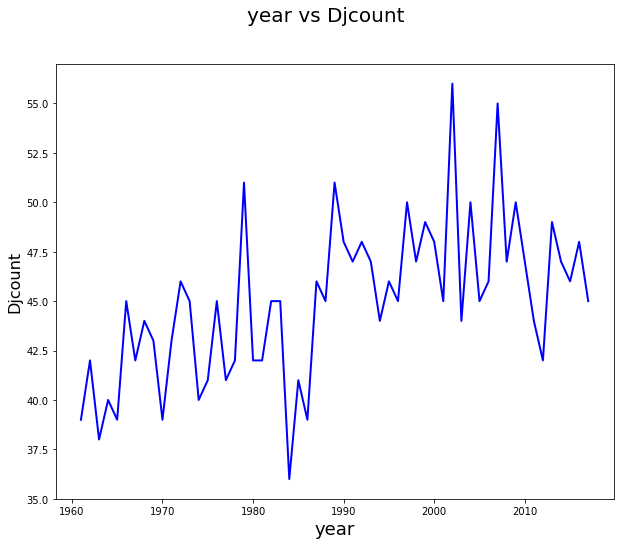

In [ ]:
sakura_Dj=sakura_data.copy()
sakura_Dj['avgcumulative'] = sakura_data.groupby(['year'])['avgtemp'].apply(lambda x: x.cumsum())
sakura_Dj.loc[:,'days'] =1
sakura_Dj['daycount'] = sakura_Dj.groupby(['year'])['days'].apply(lambda x: x.cumsum())
ii=[1,2,4,5,6,7,8,9,10,11,12]
for i in ii:
    sakura_Dj = sakura_Dj[sakura_Dj["month"] != i]
tf=[]
for i in list(range(1,1767)):
    if sakura_Dj.iloc[i].month==3  and sakura_Dj.iloc[i].day ==31:
        tf.append((sakura_Dj.iloc[i].avgcumulative)/(sakura_Dj.iloc[i].daycount))
Djcount=[]
for i in tf:
    Dj=136.75-(7.689*35.66666667)+(0.133*35.667*35.66666667)-(1.307*1.38629436) + (0.144*(i))+(0.285*(i)*(i))
    Djcount.append(round(Dj))
print(Djcount)
plt.plot(list(range(1961,2018)),Djcount, color='blue', linewidth=2)
plt.suptitle('year vs Djcount', fontsize=20)
plt.xlabel('year', fontsize=18)
plt.ylabel('Djcount', fontsize=16)
plt.show()

In [ ]:
sakura_Dj_train=sakura_data_train.copy()
sakura_Dj_train['avgcumulative'] = sakura_Dj_train.groupby(['year'])['avgtemp'].apply(lambda x: x.cumsum())
sakura_Dj_train.loc[:,'days'] =1
sakura_Dj_train['daycount'] = sakura_Dj_train.groupby(['year'])['days'].apply(lambda x: x.cumsum())
actualdate_train=[]
for i in list(range(0,18718)):
    if sakura_Dj_train.iloc[i].bloom ==1:
        actualdate_train.append(sakura_Dj_train.iloc[i-1].daycount)
ii=[1,2,4,5,6,7,8,9,10,11,12]
for i in ii:
    sakura_Dj_train = sakura_Dj_train[sakura_Dj_train["month"] != i]
tf_train=[]
for i in list(range(1,1612)):
    if sakura_Dj_train.iloc[i].month==3  and sakura_Dj_train.iloc[i].day ==31:
        tf_train.append((sakura_Dj_train.iloc[i].avgcumulative)/(sakura_Dj_train.iloc[i].daycount))
Djcount_train=[]
for i in tf_train:
    Dj=136.75-(7.689*35.66666667)+(0.133*35.667*35.66666667)-(1.307*1.38629436) + (0.144*(i))+(0.285*(i)*(i))
    Djcount_train.append(round(Dj))
Djcount_MSE=Djcount_train.copy()

In [ ]:
sakura_Dj_test=sakura_data_test.copy()
sakura_Dj_test['avgcumulative'] = sakura_Dj_test.groupby(['year'])['avgtemp'].apply(lambda x: x.cumsum())
sakura_Dj_test.loc[:,'days'] =1
sakura_Dj_test['daycount'] = sakura_Dj_test.groupby(['year'])['days'].apply(lambda x: x.cumsum())
actualdate_test=[]
for i in list(range(0,1826)):
    if sakura_Dj_test.iloc[i].bloom ==1:
        actualdate_test.append(sakura_Dj_test.iloc[i-1].daycount)
ii=[1,2,4,5,6,7,8,9,10,11,12]
for i in ii:
    sakura_Dj_test = sakura_Dj_test[sakura_Dj_test["month"] != i]
tf_test=[]
for i in list(range(1,155)):
    if sakura_Dj_test.iloc[i].month==3  and sakura_Dj_test.iloc[i].day ==31:
        tf_test.append((sakura_Dj_test.iloc[i].avgcumulative)/(sakura_Dj_test.iloc[i].daycount))
Djcount_test=[]
for i in tf_test:
    Dj=136.75-(7.689*35.66666667)+(0.133*35.667*35.66666667)-(1.307*1.38629436) + (0.144*(i))+(0.285*(i)*(i))
    Djcount_test.append(round(Dj))
Djcount_onlytest=Djcount_test.copy()    

## **4.1 Calculation of $DTS_j$** 

Now we will calcluate $DTS_j$ for each year $j$ in the training set for discrete values of $E_{a}$, varying from 5 to 40kcal ($E_{a} = 5, 6, 7, \cdots, 40 \,\rm{kcal}$), and will plot this $DTS_j$ against $E_{a}$. Also we will calculate the average of $DTS_{j}$ over the training period.

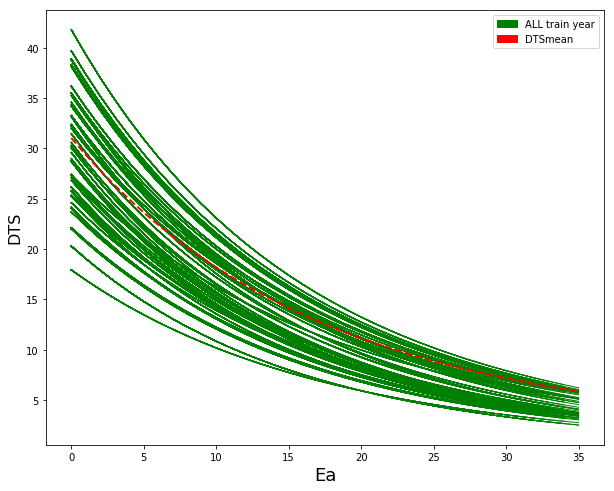

In [ ]:
sakura_data_train_DTS=sakura_data_train.copy()
sakura_data_train_DTS.loc[:,'days'] =1
sakura_data_train_DTS['daycount'] = sakura_data_train_DTS.groupby(['year'])['days'].apply(lambda x: x.cumsum())
sakura_data_train_DTS = sakura_data_train_DTS[sakura_data_train_DTS.groupby('year')['bloom'].apply(lambda x: x.shift().eq(1).cumsum().eq(0))]

Ts=17+273.15
R=8.314
a1=0
Dt=0
KJ = 4184
year_num = 0
Ea_number = 0
DTS_database = np.zeros((52, 37))
for i in trainyear_sakura:
    year_num = year_num+1
    Ea_number = 0
    DTS_database[year_num - 1][0] = i
    for i in list(range(5,41)):
        Ea_number= Ea_number+1
        Ea=i*KJ
        for i in list(range(int(round(Djcount[a1])), 1 + int(round(actualdate_train[a1])))):
            Total = np.exp(Ea * ((sakura_data_train_DTS.iloc[i].avgtemp+273.15) - Ts) / (R * (sakura_data_train_DTS.iloc[i].avgtemp+273.15) * Ts))
            Dt += Total
        DTS_database[year_num-1][Ea_number]= Dt
        Dt = 0
    a1+=1

DTS_DATA = []
for x in range(52):
    DTS_DATA = []
    for i in range(1, 37):
        DTS_DATA.append(DTS_database[x][i])
        plt.plot(DTS_DATA, color='green', linewidth=1)
        plt.xlabel('Ea', fontsize=18)
        plt.ylabel('DTS', fontsize=16)
bluePatch = mpatches.Patch(color='green', label='ALL train year')
redPatch = mpatches.Patch(color='red', label='DTSmean')
plt.legend(handles=[bluePatch, redPatch])

sakura_data_train_DTS_Mean=sakura_data_train.copy()
sakura_data_train_DTS_Mean.loc[:,'daycount'] =1
sakura_data_train_DTS_Mean['cum_sum'] = sakura_data_train_DTS_Mean.daycount.cumsum()
sakura_data_train_DTS_Mean['daywisecumulative'] = sakura_data_train_DTS_Mean.groupby(['year'])['daycount'].apply(lambda x: x.cumsum())
sakura_data_train_optimalEa=sakura_data_train_DTS_Mean.copy()
sakura_data_train_=sakura_data_train_DTS_Mean.copy()

z = 0
list_year=[]
final_listyear=[]
product=[]
for i in range(0,18718):
    if sakura_data_train_DTS_Mean.iloc[i].year == year[z] and int(sakura_data_train_DTS_Mean.iloc[i].daywisecumulative) == Djcount_train[z]:
        list_year.append(sakura_data_train_DTS_Mean.iloc[i-1].cum_sum)
        z+=1
        if z==len(Djcount_train):
            break
v=0
product=[]
for i in range(5,41):
    final_year = []
    for ii in list_year:
        Djcount_train=int(ii)
        Total=0
        while(sakura_data_train_DTS_Mean.iloc[Djcount_train].daywisecumulative!=actualdate_train[v]):
            Total+=np.exp(((i*4184) * ((sakura_data_train_DTS_Mean.iloc[Djcount_train].avgtemp + 273.15) - 290.15) / (R * (sakura_data_train_DTS_Mean.iloc[Djcount_train].avgtemp + 273.15) * 290.15)))
            Djcount_train += 1
            if (sakura_data_train_DTS_Mean.iloc[Djcount_train].daywisecumulative==actualdate_train[v]):
                Total += np.exp(((i * 4184) * ((sakura_data_train_DTS_Mean.iloc[Djcount_train].avgtemp + 273.15) - 290.15) / (R * (sakura_data_train_DTS_Mean.iloc[Djcount_train].avgtemp + 273.15) * 290.15)))
                final_year.append(Total)
        v+=1
    product.append(final_year)
    v=0
DTSmean=[]
for i in product:
    DTSmean.append(mean(i))
plt. plot(DTSmean, linewidth=2.0,linestyle='--', color='r')
plt.show()

## **4.2 Finding optimal $E_{a}^{*}$ :** 

Using the same $E_{a}$ values and calculated $DTS_{mean}$ from 4.1, we will try to predict the bloom date $BD_{j}$ for each of the training years. We will find the mean squared error relative to the actual $BD$ and will plot it against $E_{a}$. Our target is to find the optimal $E_{a}^{*}$ that minimizes that error on the training data.

Optimal Ea= 28


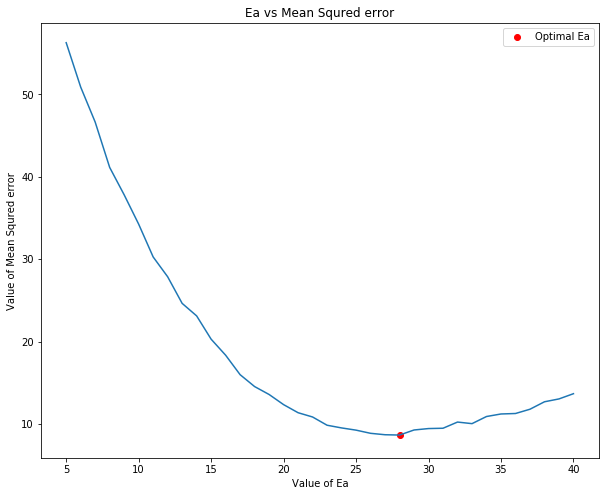

In [ ]:
k=0
Ea=range(5,41)
z = 0
product=[]

for i in list_year:
    final_year = []
    for ii in range(0,36):
        Total = 0
        Djcount_MSE=int(i)
        while(Total < DTSmean[k]):
            Total += np.exp((Ea[k]*4184 * ((sakura_data_train_optimalEa.iloc[Djcount_MSE].avgtemp + 273.15) - 290.15) / (R * (sakura_data_train_optimalEa.iloc[Djcount_MSE].avgtemp + 273.15) * 290.15)))
            Djcount_MSE+=1
            if Total >= DTSmean[k]:
                final_year.append(int(sakura_data_train_optimalEa.iloc[Djcount_MSE-1].daywisecumulative))
        k+=1
    product.append(final_year)

    k=0
ans=[]
for i in range(0,36):
    ans.append([item[i] for item in product])
mean_squared_error=[]
for i in range(len(Ea)):
    error = np.array(actualdate_train) - np.array(ans[i])
    mean_squared_error.append(mean(error ** 2))

optimal_Ea=0
plt.plot(Ea,mean_squared_error)
for i in range(len(mean_squared_error)):
    if min(mean_squared_error)==mean_squared_error[i]:
        optimal_Ea = Ea[i]
        plt.scatter(optimal_Ea, mean_squared_error[i],color='red',label="Optimal Ea")
        print("Optimal Ea=",optimal_Ea)
        break
plt.title("Ea vs Mean Squred error")
plt.xlabel('Value of Ea')
plt.ylabel("Value of Mean Squred error")
plt.legend(loc='upper right')
plt.show()    

## **4.3 Prediction** 

Using the $D_j$ dates from problem 4, the average $DTS_{mean}$ from 4.1, and the best-fit $E_{a}^{*}$ from 4.2, we will predict the bloom-dates $BD_j$ for the years in the test set. To determine the error between our predicted $BD_j$ values and the actual values,we will use coefficient of determination ($R^2$ score).

In [ ]:
sakura_data_test_DTSMean=sakura_data_test
sakura_data_test_DTSMean.loc[:,'daycount'] =1
sakura_data_test_DTSMean['cum_sum'] = sakura_data_test_DTSMean.daycount.cumsum()
sakura_data_test_DTSMean['daywisecumulative'] = sakura_data_test_DTSMean.groupby(['year'])['daycount'].apply(lambda x: x.cumsum())
dtsmean=mean(DTSmean)
k=0
z = 0
list_year=[]
final_listyear=[]
product=[]
for i in range(0,1826):
    if sakura_data_test_DTSMean.iloc[i].year == testyear_sakura[z] and int(sakura_data_test_DTSMean.iloc[i].daywisecumulative) == Djcount_onlytest[z]:
        list_year.append(sakura_data_test_DTSMean.iloc[i - 1].cum_sum)
        z += 1
        if z == len(Djcount_onlytest):
            break
for i in list_year:
    Total = 0
    Djcount_onlytest=int(i)
    while(Total < dtsmean):
        Total += np.exp((optimal_Ea*4184 * ((sakura_data_test_DTSMean.iloc[Djcount_onlytest].avgtemp + 273.15) - 290.15) / (R * (sakura_data_test_DTSMean.iloc[Djcount_onlytest].avgtemp + 273.15) * 290.15)))
        Djcount_onlytest+=1
        if Total >= dtsmean:
            pass
    final_listyear.append(int(sakura_data_test_DTSMean.iloc[Djcount_onlytest-1].daywisecumulative))
r2_Dts = r2_score(actualdate_test, final_listyear)    
print("Predicted test year BD by average DTSmean:",final_listyear)
predictionerror=np.abs(list(np.array(actualdate_test) - np.array(final_listyear)))
print(predictionerror)
print('R2 score:',r2_score(actualdate_test, final_listyear))

C:\Users\Ananda\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Ananda\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\Ananda\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

Predicted test year BD by average DTSmean: [94, 97, 98, 96, 94]
[16.  9.  6.  7. 13.]
R2 score: -3.3075801749271143


## **4.4 Discussion regarding improvements:** 


1. One major assumption is Arrhenius’ equation for Linear Regression Model. This can be written as follows:
 k=A.exp(−E_a/RT )=  exp(B−E_a/(R.T) ).
In this equation A is a model constant which is generally used after a logarithm transformation which is  B= ln(A)[Ratkowsky, 1990].In case of our model we followed DTS method.This method got a major drawback. This is all about the estimation of  the parameter B in the Arrhenius’ equation. The outcome from this also declares that the developmental rates at different constant temperatures cannot be predicted. 


2. To predetermine the standard temperature is somewhat subjective, and for different species it could be challenging [Ikemoto, 2005; Shi et al., 2013] .So the use of 298.15 K for all species might not be the proper approach. 


3. According to this project [Peijian Shi,2017 ] accumulated developmental progress (ADP) method might be the answer. Moreover we can use neural network or deep learning process.


# **5. Predicting bloom-date via neural network** 

Now we will build a neural network and will train it on the data from the training years. We will use this model to predict the bloom-dates for each year in the test set. For evaluation purpose we will use the coefficient of determination (R2 score). 

## **5.1 Feature engineering(for training data):**

In [ ]:
cols = ['serial']
sakura_data_train_Neural = sakura_data_train_Neural.drop(cols,axis=1)
sakura_data_train_Neural.loc[:,'bloomdaycount'] =1
sakura_data_train_Neural['daywisecumulative'] = sakura_data_train_Neural.groupby(['year'])['bloomdaycount'].apply(lambda x: x.cumsum())
sakura_data_train_Neural['localpressurecumulative'] = sakura_data_train_Neural.groupby(['year'])['local pressure'].apply(lambda x: x.cumsum())
sakura_data_train_Neural['sunhourscumulative'] = sakura_data_train_Neural.groupby(['year'])['sun hours'].apply(lambda x: x.cumsum())
sakura_data_train_Neural=sakura_data_train_Neural.rename(columns = {'avg humid':'avghumid'})
sakura_data_train_Neural['avghumidcumulative'] = sakura_data_train_Neural.groupby(['year'])['avghumid'].apply(lambda x: x.cumsum())
sakura_data_train_Neural=sakura_data_train_Neural.rename(columns = {'min humid':'minhumid'})
sakura_data_train_Neural['minhumidmean'] = sakura_data_train_Neural.groupby(['year'])['minhumid'].mean()
sakura_data_train_Neural['minhumidmean'] = sakura_data_train_Neural['minhumidmean'].fillna(sakura_data_train_Neural.groupby('year')['minhumid'].transform('mean'))
sakura_data_train_Neural=sakura_data_train_Neural.rename(columns = {'avg temp':'avgtemp'})
sakura_data_train_Neural['avgtempmean'] = sakura_data_train_Neural.groupby(['year'])['avgtemp'].mean()
sakura_data_train_Neural['avgtempmean'] = sakura_data_train_Neural['avgtempmean'].fillna(sakura_data_train_Neural.groupby('year')['avgtemp'].transform('mean'))
sakura_data_train_Neural=sakura_data_train_Neural.rename(columns = {'max temp':'maxtemp'})
sakura_data_train_Neural['maxtempmcummulative'] = sakura_data_train_Neural.groupby(['year'])['maxtemp'].apply(lambda x: x.cumsum())
sakura_data_train_Neural=sakura_data_train_Neural.rename(columns = {'min temp':'mintemp'})
sakura_data_train_Neural['mintempmean'] = sakura_data_train_Neural.groupby(['year'])['mintemp'].mean()
sakura_data_train_Neural['mintempmean'] = sakura_data_train_Neural['mintempmean'].fillna(sakura_data_train_Neural.groupby('year')['mintemp'].transform('mean'))


sakura_data_train_Neural = sakura_data_train_Neural[sakura_data_train_Neural["daywisecumulative"] == 83]
cols = ['day','local pressure','month','bloomdaycount','sun hours','year','bloom','avghumid','sea pressure','daywisecumulative','minhumidmean','maxtemp','avgtemp','avghumid','minhumid','mintemp','total preci','hr1 preci','min10 preci']
sakura_data_train_Neural = sakura_data_train_Neural.drop(cols,axis=1)
sakura_data_train_Neural.to_csv('neuraltrain.csv')
neuraltrain = pd.read_csv('neuraltrain.csv',index_col=1)
X_train= neuraltrain.values.tolist()

## **5.2 Feature engineering(for test data):**

In [ ]:
cols = ['serial']
sakura_data_test_Neural = sakura_data_test_Neural.drop(cols,axis=1)
sakura_data_test_Neural.loc[:,'bloomdaycount'] =1
sakura_data_test_Neural['daywisecumulative'] = sakura_data_test_Neural.groupby(['year'])['bloomdaycount'].apply(lambda x: x.cumsum())
sakura_data_test_Neural['localpressurecumulative'] = sakura_data_test_Neural.groupby(['year'])['local pressure'].apply(lambda x: x.cumsum())
sakura_data_test_Neural['sunhourscumulative'] = sakura_data_test_Neural.groupby(['year'])['sun hours'].apply(lambda x: x.cumsum())
sakura_data_test_Neural=sakura_data_test_Neural.rename(columns = {'avg humid':'avghumid'})
sakura_data_test_Neural['avghumidcumulative'] = sakura_data_test_Neural.groupby(['year'])['avghumid'].apply(lambda x: x.cumsum())
sakura_data_test_Neural=sakura_data_test_Neural.rename(columns = {'min humid':'minhumid'})
sakura_data_test_Neural['minhumidmean'] = sakura_data_test_Neural.groupby(['year'])['minhumid'].mean()
sakura_data_test_Neural['minhumidmean'] = sakura_data_test_Neural['minhumidmean'].fillna(sakura_data_test_Neural.groupby('year')['minhumid'].transform('mean'))
sakura_data_test_Neural=sakura_data_test_Neural.rename(columns = {'avg temp':'avgtemp'})
sakura_data_test_Neural['avgtempmean'] = sakura_data_test_Neural.groupby(['year'])['avgtemp'].mean()
sakura_data_test_Neural['avgtempmean'] = sakura_data_test_Neural['avgtempmean'].fillna(sakura_data_test_Neural.groupby('year')['avgtemp'].transform('mean'))
sakura_data_test_Neural=sakura_data_test_Neural.rename(columns = {'max temp':'maxtemp'})
sakura_data_test_Neural['maxtempmcummulative'] = sakura_data_test_Neural.groupby(['year'])['maxtemp'].apply(lambda x: x.cumsum())
sakura_data_test_Neural=sakura_data_test_Neural.rename(columns = {'min temp':'mintemp'})
sakura_data_test_Neural['mintempmean'] = sakura_data_test_Neural.groupby(['year'])['mintemp'].mean()
sakura_data_test_Neural['mintempmean'] = sakura_data_test_Neural['mintempmean'].fillna(sakura_data_test_Neural.groupby('year')['mintemp'].transform('mean'))


sakura_data_test_Neural = sakura_data_test_Neural[sakura_data_test_Neural["daywisecumulative"] == 83]
cols = ['day','local pressure','month','bloomdaycount','sun hours','avghumid','bloom','daywisecumulative','year','sea pressure','minhumidmean','maxtemp','avgtemp','avghumid','minhumid','mintemp','total preci','hr1 preci','min10 preci']
sakura_data_test_Neural = sakura_data_test_Neural.drop(cols,axis=1)

sakura_data_test_Neural.to_csv('neuraltest.csv')
neuraltest = pd.read_csv('neuraltest.csv',index_col=1)
X_test = neuraltest.values.tolist()

## **5.3 ANN:**

In [ ]:
clf = MLPRegressor(hidden_layer_sizes=(30,20,10), activation='identity', solver='lbfgs', learning_rate='adaptive',max_iter=1500)
clf = clf.fit(X_train, actualdate_train)
acc_test = clf.score(X_test,actualdate_test)
predict = clf.predict(X_test)
print(acc_test)
print("Predicted days:",predict)
predict_nn=[]
for value in predict:
    predict_nn.append(math.floor(value))
r2_neural_1 = r2_score(actualdate_test, predict_nn)    
print("Predicted days:",predict_nn)
print("Coefficient of determination for Neural Network:",r2_score(actualdate_test, predict_nn))

0.9126457559171168
Predicted days: [80.43332839 86.37385053 90.20357534 88.56356927 80.95595643]
Predicted days: [80, 86, 90, 88, 80]
Coefficient of determination for Neural Network: 0.8979591836734694


## **5.4 ANN with data scaling**

In [ ]:

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
clf = MLPRegressor(hidden_layer_sizes=(50,25,1), activation='identity', solver='lbfgs', learning_rate='adaptive',max_iter=500)
clf = clf.fit(X_train, actualdate_train)
acc_test = clf.score(X_test,actualdate_test)
predict = clf.predict(X_test)
print(acc_test)
print("Predicted days:",predict)
predict_nn_DS=[]
for value in predict:
    predict_nn_DS.append(math.floor(value))
r2_neural_2 = r2_score(actualdate_test, predict_nn_DS)

print("Predicted days:",predict_nn_DS)
print("Coefficient of determination for Neural Network:",r2_score(actualdate_test, predict_nn_DS))

0.5799802400639653
Predicted days: [84.69681347 89.04889532 89.55956416 87.85317863 83.09959347]
Predicted days: [84, 89, 89, 87, 83]
Coefficient of determination for Neural Network: 0.6064139941690962


# **6. Comparison:** 
Here we will compare the performance (via $R^2$ score) of the 3 implementations above: 


`i) 600 Degree Rule` 

`ii) DTS method`

`iii) neural network approach`



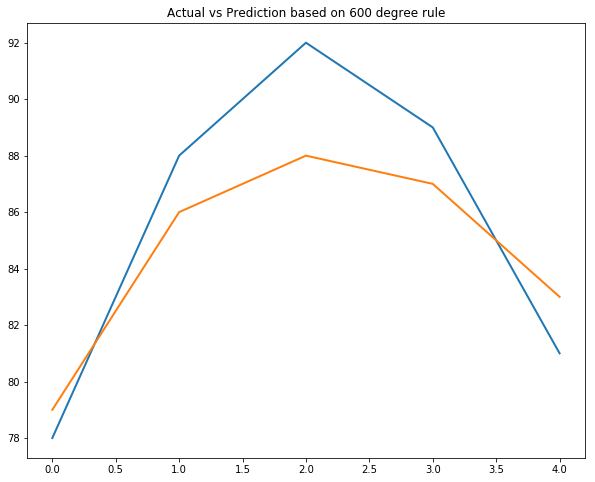

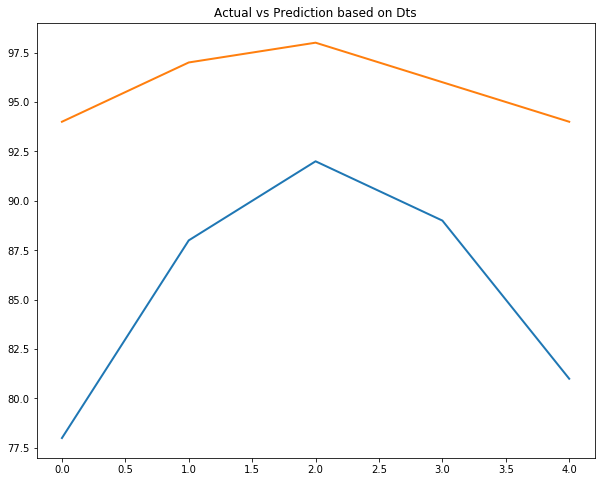

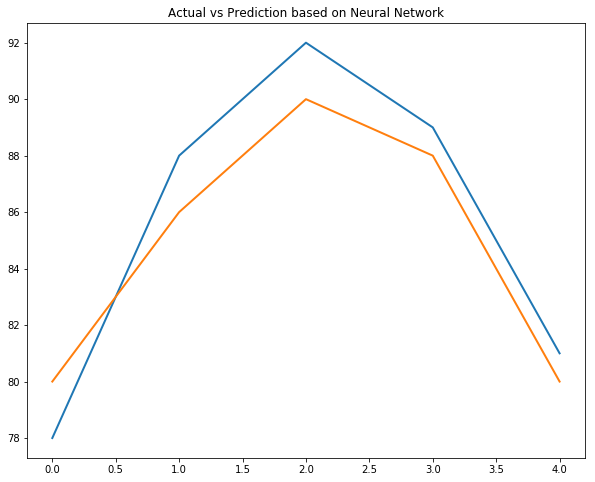


 *** Coefficient of Determination values: 
for 600 Degree Rule = 0.6793002915451896
for DTS Method = -3.3075801749271143
for Neural Network = 0.8979591836734694
for Neural Network(With data scaling) = 0.6064139941690962
According to the data we can see that the most successful model is ANN


In [ ]:
plt. plot(actualdate_test, linewidth=2.0)
plt. plot(prediction_600, linewidth=2.0)
plt.title("Actual vs Prediction based on 600 degree rule")
plt.show()
plt. plot(actualdate_test, linewidth=2.0)
plt. plot(final_listyear, linewidth=2.0)
plt.title("Actual vs Prediction based on Dts")
plt.show()
plt. plot(actualdate_test, linewidth=2.0)
plt. plot(predict_nn, linewidth=2.0)
plt.title("Actual vs Prediction based on Neural Network")
plt.show()

print('\n *** Coefficient of Determination values: ')
print('for 600 Degree Rule =', r2_600)
print('for DTS Method =', r2_Dts)
print('for Neural Network =', r2_neural_1)
print('for Neural Network(With data scaling) =', r2_neural_2)

print("According to the data we can see that the most successful model is ANN")




In [ ]:
print("Predicted days based on 600 degree rule:",prediction_600)
print("Predicted days based on DTSmean:",final_listyear)
print("Predicted days based on Neural Network",predict_nn)
print("Predicted days based on Neural Network(With Data scaling)",predict_nn_DS)

Predicted days based on 600 degree rule: [79.0, 86.0, 88.0, 87.0, 83.0]
Predicted days based on DTSmean: [94, 97, 98, 96, 94]
Predicted days based on Neural Network [80, 86, 90, 88, 80]
Predicted days based on Neural Network(With Data scaling) [84, 89, 89, 87, 83]


# **7. Trends of the Sakura blooming phenomenon** 


Based on the data from the past 60 years, we will do investigation & i will try to discuss trends in the sakura hibernation ($D_{j}$) and blooming ($BD_{j}$) phenomena in Tokyo.

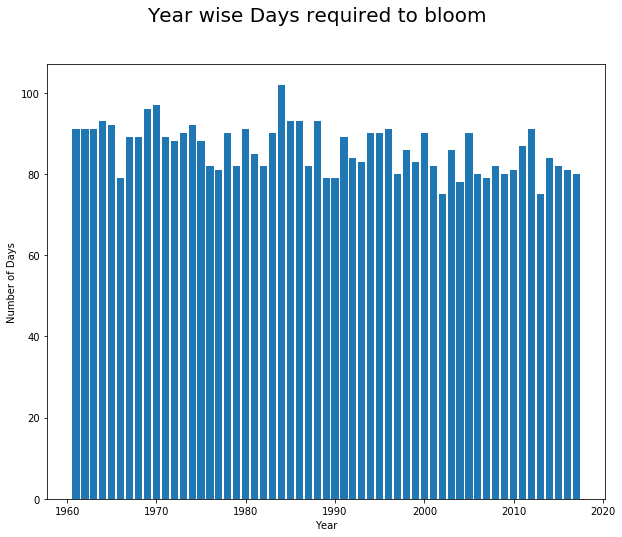

In [ ]:
sakura_data['avgcumulative'] = sakura_data.groupby(['year'])['avgtemp'].apply(lambda x: x.cumsum())
sakura_data.loc[:,'days'] =1
sakura_data['daycount'] = sakura_data.groupby(['year'])['days'].apply(lambda x: x.cumsum())
actualdate=[]
for i in list(range(0,20544)):
    if sakura_data.iloc[i].bloom ==1:
        actualdate.append(sakura_data.iloc[i].daycount)

plt.bar(range(1961,2018),actualdate)
plt.ylabel("Number of Days")
plt.xlabel("Year")
plt.suptitle('Year wise Days required to bloom', fontsize=20)
plt.show()

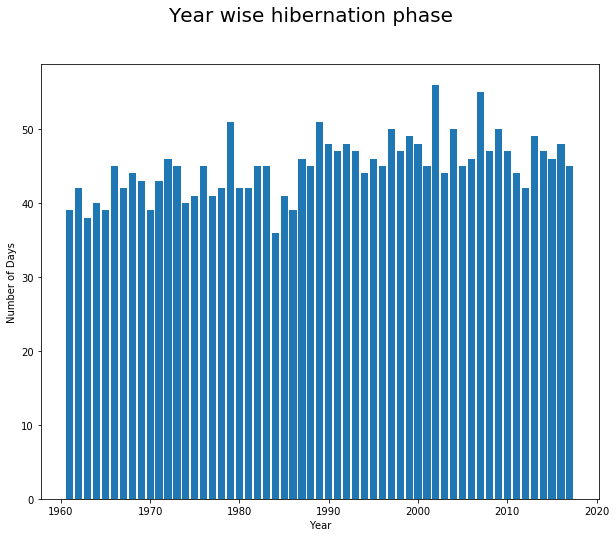

In [ ]:
plt.bar(range(1961,2018),Djcount)
plt.ylabel("Number of Days")
plt.xlabel("Year")
plt.suptitle('Year wise hibernation phase', fontsize=20)
plt.show()

In [ ]:
table = BeautifulTable()
table.column_headers = ["Year", "1st Bloom Day count", "HibernationPhase","Difference"]
Year=range(1961,2018)
for i in range(0,57):
    table.append_row([range(1961,2018)[i],actualdate [i],Djcount[i],actualdate [i]-Djcount[i]])
print(table)

+------+---------------------------------------+------------------+------------+
| Year |          1st Bloom Day count          | HibernationPhase | Difference |
+------+---------------------------------------+------------------+------------+
| 1961 |                 91.0                  |       39.0       |    52.0    |
+------+---------------------------------------+------------------+------------+
| 1962 |                 91.0                  |       42.0       |    49.0    |
+------+---------------------------------------+------------------+------------+
| 1963 |                 91.0                  |       38.0       |    53.0    |
+------+---------------------------------------+------------------+------------+
| 1964 |                 93.0                  |       40.0       |    53.0    |
+------+---------------------------------------+------------------+------------+
| 1965 |                 92.0                  |       39.0       |    53.0    |
+------+--------------------

Tokyo has four seasons. Winters are dry and cool, spring is lovely, summer is wet followed by hot and humid, autumn starts out wet and finishes with some of the year's best weather.Blossoming depends first & foremost on the weather.High temperatures in early March are definitely one of the major factors behind the early full bloom in Tokyo.Here is a table that represents cummulative sum of Max. Temp for the 1st seven days in case of march-

In [ ]:
sakura_data = sakura_data[sakura_data.groupby('year')['bloom'].apply(lambda x: x.shift().eq(1).cumsum().eq(0))]
for i in range(2,13):
    sakura_data = sakura_data[sakura_data["month"] != i]
for i in range(8,32):
    sakura_data = sakura_data[sakura_data["day"] != i]
sakura_data=sakura_data.rename(columns = {'max temp':'maxtemp'})
sakura_data['maxtempcumulative'] = sakura_data.groupby(['year'])['maxtemp'].apply(lambda x: x.cumsum())

for i in range(1,7):
    sakura_data = sakura_data[sakura_data["day"] != i]
my_list = sakura_data["maxtempcumulative"].tolist()
my_listtt=sakura_data["year"].tolist()
table = BeautifulTable()
table.column_headers = ["Year", "Maxtempcumulative","Bloom Date"]
for i in range(0,57):
    table.append_row([my_listtt[i],my_list[i],actualdate[i]])
print(table)

+------+-------------------+------------+
| Year | Maxtempcumulative | Bloom Date |
+------+-------------------+------------+
| 1961 |       61.3        |    91.0    |
+------+-------------------+------------+
| 1962 |       71.8        |    91.0    |
+------+-------------------+------------+
| 1963 |       73.1        |    91.0    |
+------+-------------------+------------+
| 1964 |       67.8        |    93.0    |
+------+-------------------+------------+
| 1965 |       54.4        |    92.0    |
+------+-------------------+------------+
| 1966 |       74.3        |    79.0    |
+------+-------------------+------------+
| 1967 |       54.0        |    89.0    |
+------+-------------------+------------+
| 1968 |       83.6        |    89.0    |
+------+-------------------+------------+
| 1969 |       66.5        |    96.0    |
+------+-------------------+------------+
| 1970 |       56.6        |    97.0    |
+------+-------------------+------------+
| 1971 |       53.2        |    89

In [ ]:
Avg=[]
product=[[91.0, 91.0, 91.0, 93.0, 92.0, 79.0, 89.0, 89.0, 96.0, 97.0],[89.0, 88.0, 90.0, 92.0, 88.0, 82.0, 81.0, 90.0, 82.0, 91.0],[85.0, 82.0, 90.0, 102.0, 93.0, 93.0, 82.0, 93.0, 79.0, 79.0],[89.0, 84.0, 83.0, 90.0, 90.0, 91.0, 80.0, 86.0, 83.0, 90.0],[82.0, 75.0, 86.0, 78.0, 90.0, 80.0, 79.0, 82.0, 80.0, 81.0]]
from statistics import mean
for i in product:
    Avg.append(int(mean(i)))
cycle=(10,20,30,40,50)
table = BeautifulTable()
table.column_headers = ["Cycle(10 Years each)", "Avg Bloom Date"]
for i in range(0,5):
    table.append_row([cycle[i],Avg[i]])
print(table)

+----------------------+----------------+
| Cycle(10 Years each) | Avg Bloom Date |
+----------------------+----------------+
|          10          |       90       |
+----------------------+----------------+
|          20          |       87       |
+----------------------+----------------+
|          30          |       87       |
+----------------------+----------------+
|          40          |       86       |
+----------------------+----------------+
|          50          |       81       |
+----------------------+----------------+


Increasingly early arrival of the cherry blossoms, known as sakura, reflected steadily rising global temperatures.Here is a table that represents avg bloom-date in a 10 years cycle.If we see this carefully we will notice that The average Bloom date value is decreasing day by day.Which also supports the theory of  early blooming due to global warming

# **8. Conclusion**

Bloom date is strongly related to average temperatures, maximum temperatures and minimum temperatures.As we see that, among the four models, Neural Network(Without data Scaling) method accuracy is the best of all. But we also need to admit that here number of training data were only 52 which is very small for a neural network to perform its fullest. But with this such small dataset, neural network works just fine with average R square of around 0.9 . And lastly, 600 degree rule is the simplest among all four methods which is computationally cheaper.

# **9. References**

1. https://www.sciencedirect.com/science/article/pii/S0168192317301296?via%3Dihub
2. https://link.springer.com/article/10.1007/s13143-016-0033-9
3. https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html
4. https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
5. https://pubs.acs.org/doi/abs/10.1021/ed061p494?journalCode=jceda8    